In [1]:
import os
import sys
import numpy as np
import pandas as pd
#import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, "data_weather_prediction")
path_data_ecad = os.path.join(path_root, "data_weather_prediction", "ECAD_DATA")
folders = ['BASEL',
         'BUDAPEST',
         'DE_BILT',
         'DRESDEN',
         'DUSSELDORF',
         'HEATHROW',
         'KASSEL',
         #'LEIPZIG',
         'LJUBLJANA',
         'MAASTRICHT',
         'MALMO',
         'MONTELIMAR',
         'MUENCHEN',
         'OSLO',
         'PERPIGNAN',
         'ROMA',
         'SONNBLICK',
         'STOCKHOLM',
         'TOURS']# folders = os.listdir(path_data)
feature_types = {"TG_": "temp_mean",
                 "TN_": "temp_min",
                 "TX_": "temp_max",
                 "SS_": "sunshine",
                 "CC_": "cloud_cover",
                 #"DD_": "wind_direction",
                 "FG_": "wind_speed",
                 "FX_": "wind_gust",
                 "HU_": "humidity",
                 "PP_": "pressure",
                 "QQ_": "global_radiation",
                 "RR_": "precipitation",
                 "SS_": "sunshine"}

In [4]:
os.listdir(path_data_ecad)

['AACHEN',
 'BASEL',
 'BONN',
 'BUDAPEST',
 'DE_BILT',
 'DRESDEN',
 'DUSSELDORF',
 'ESSEN',
 'HEATHROW',
 'KASSEL',
 'LEIPZIG',
 'LJUBLJANA',
 'MAASTRICHT',
 'MALMO',
 'MALMO_A',
 'MONTELIMAR',
 'MUENCHEN',
 'OSLO',
 'PERPIGNAN',
 'ROMA',
 'SONNBLICK',
 'STOCKHOLM',
 'STOCKHOLM_A',
 'STOCKHOLM_SOL',
 'TOURS']

In [5]:
def find_startline(filename, string_to_search):
    with open(filename, 'r') as read_obj:
        # Read all lines in the file one by one
        for i, line in enumerate(read_obj):
            # For each line, check if line contains the string
            if string_to_search in line:
                return i
        return False

In [6]:
year_span = 10
year_start = 2000
date_low = int(str(year_start) + "0101")  #20050101
date_high = int(str(year_start + year_span) + "0101") #20150101
print(f"Collect from {date_low} until {date_high}")


data_collection = {}

for folder in folders:
    print(f"Folder: {folder}")
    counts = 0
    path = os.path.join(path_data_ecad, folder)
    #data_collection[folder] = {}
    for file in os.listdir(path):
        if file[:3] in feature_types.keys():
            header_line = find_startline(os.path.join(path, file), "SOUID,")
            if header_line:
                df = pd.read_csv(os.path.join(path, file), header=header_line,
                                skip_blank_lines=False)
                df.columns = [x.strip() for x in df.columns]
                df_select = df[(df["DATE"] >= date_low) & (df["DATE"] <= date_high)]
                # Add column values to collection
                if counts == 0:
                    # Add date
                    data_collection["DATE"] = df_select["DATE"].values
                    data_collection["MONTH"] = [int(str(x)[4:6]) for x in df_select["DATE"].values]
                data_collection[folder + "_"+ feature_types[file[:3]]] = df_select[file[:2]].values
        counts += 1

Collect from 20000101 until 20100101
Folder: BASEL
Folder: BUDAPEST
Folder: DE_BILT
Folder: DRESDEN
Folder: DUSSELDORF
Folder: HEATHROW
Folder: KASSEL
Folder: LJUBLJANA
Folder: MAASTRICHT
Folder: MALMO
Folder: MONTELIMAR
Folder: MUENCHEN
Folder: OSLO
Folder: PERPIGNAN
Folder: ROMA
Folder: SONNBLICK
Folder: STOCKHOLM
Folder: TOURS


In [7]:
dataset = pd.DataFrame.from_dict(data_collection)
dataset.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_sunshine,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,89,10286,20,3,0,29,16,...,7,16,97,10275,25,4,0,85,72,98
1,20000102,1,8,87,10318,25,0,0,36,27,...,20,20,99,10293,17,16,0,79,66,92
2,20000103,1,5,81,10314,50,0,37,22,1,...,28,34,91,10267,27,0,4,81,66,96
3,20000104,1,7,79,10262,63,35,69,39,5,...,46,49,95,10222,11,44,0,86,64,108
4,20000105,1,5,90,10246,51,7,37,60,38,...,29,36,95,10209,39,4,16,80,64,95


In [8]:
dataset.shape

(3654, 174)

In [9]:
drop_columns = []

for column in dataset.columns:
    unvalid_values = np.sum(dataset[column].values == -9999)
    percentage_unvalid = 100 * unvalid_values/(year_span*365.25)
    if percentage_unvalid > 1:
        print(column, f"unvalid fraction: {percentage_unvalid:.3f}")    
    if percentage_unvalid > 5:
        print("--> drop column,", column)
        drop_columns.append(column)

dataset = dataset.drop(columns=drop_columns)

DRESDEN_global_radiation unvalid fraction: 2.793
KASSEL_cloud_cover unvalid fraction: 61.656
--> drop column, KASSEL_cloud_cover
KASSEL_global_radiation unvalid fraction: 1.780
MALMO_cloud_cover unvalid fraction: 100.041
--> drop column, MALMO_cloud_cover
MALMO_humidity unvalid fraction: 7.146
--> drop column, MALMO_humidity
MALMO_pressure unvalid fraction: 100.041
--> drop column, MALMO_pressure
MONTELIMAR_sunshine unvalid fraction: 49.993
--> drop column, MONTELIMAR_sunshine
OSLO_sunshine unvalid fraction: 2.026
PERPIGNAN_sunshine unvalid fraction: 49.993
--> drop column, PERPIGNAN_sunshine
ROMA_precipitation unvalid fraction: 8.159
--> drop column, ROMA_precipitation
ROMA_temp_min unvalid fraction: 1.287
ROMA_temp_max unvalid fraction: 1.232
STOCKHOLM_humidity unvalid fraction: 6.489
--> drop column, STOCKHOLM_humidity
STOCKHOLM_sunshine unvalid fraction: 4.517
TOURS_sunshine unvalid fraction: 49.993
--> drop column, TOURS_sunshine


In [10]:
dataset.shape

(3654, 165)

In [42]:
variables = set()

for folder in folders:
    print("---------", folder, "---------")
    found_variables = [x.split(folder + "_")[1] for x in dataset.columns if x.startswith(folder + "_")]
    variables.update(set(found_variables))
    print(found_variables)


--------- BASEL ---------
['cloud_cover', 'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']
--------- BUDAPEST ---------
['cloud_cover', 'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine', 'temp_mean', 'temp_max']
--------- DE_BILT ---------
['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']
--------- DRESDEN ---------
['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'global_radiation', 'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']
--------- DUSSELDORF ---------
['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']
--------- HEATHROW ---------
['cloud_cover', 'humidity', 'pressure', 'global_radiation', 'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']
--------- KASSEL

In [31]:
variables

{'cloud_cover',
 'global_radiation',
 'humidity',
 'precipitation',
 'pressure',
 'sunshine',
 'temp_max',
 'temp_mean',
 'temp_min',
 'wind_gust',
 'wind_speed'}

In [18]:
for column in dataset.columns:
    idx = np.where(dataset[column].values == -9999)[0]
    if idx.shape[0] > 0:
        #print(idx.shape[0])
        mean_value = dataset[column][dataset[column] != -9999].mean()
        print(f"Replace {idx.shape[0]} -9999 values in {column} by mean of {mean_value}")
        dataset[column].values[idx] = dataset[column][dataset[column] != -9999].mean()

Replace 1 -9999 values in BUDAPEST_humidity by mean of 65.650698056392
Replace 1 -9999 values in BUDAPEST_pressure by mean of 10169.350944429236
Replace 1 -9999 values in DE_BILT_cloud_cover by mean of 5.303312346016972
Replace 28 -9999 values in DE_BILT_humidity by mean of 81.79426365140651
Replace 28 -9999 values in DE_BILT_global_radiation by mean of 119.09100937672366
Replace 28 -9999 values in DE_BILT_sunshine by mean of 47.447876447876446
Replace 102 -9999 values in DRESDEN_global_radiation by mean of 126.35304054054055
Replace 11 -9999 values in DRESDEN_sunshine by mean of 48.15783694757069
Replace 26 -9999 values in DUSSELDORF_wind_speed by mean of 39.64195148842337
Replace 26 -9999 values in DUSSELDORF_wind_gust by mean of 105.92337375964719
Replace 12 -9999 values in DUSSELDORF_global_radiation by mean of 114.7386051619989
Replace 12 -9999 values in DUSSELDORF_sunshine by mean of 43.24190005491488
Replace 2 -9999 values in HEATHROW_cloud_cover by mean of 5.272179627601314
Rep

In [43]:
for column in dataset.columns:
    unvalid_values = np.sum(dataset[column].values == -9999)
    if unvalid_values > 0:
        print(column)

In [20]:
dataset.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,89,10286,20,3,0,29,16,...,-93,7,16,97,10275,25,4,85,72,98
1,20000102,1,8,87,10318,25,0,0,36,27,...,5,20,20,99,10293,17,16,79,66,92
2,20000103,1,5,81,10314,50,0,37,22,1,...,-10,28,34,91,10267,27,0,81,66,96
3,20000104,1,7,79,10262,63,35,69,39,5,...,25,46,49,95,10222,11,44,86,64,108
4,20000105,1,5,90,10246,51,7,37,60,38,...,-18,29,36,95,10209,39,4,80,64,95


In [21]:
dataset.shape

(3654, 165)

In [22]:
dataset.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,74.510673,10178.761631,133.038041,23.484948,46.611932,110.227969,69.891352,...,51.042146,114.706349,36.772578,78.187192,10166.392447,136.978654,18.610016,122.058019,78.605364,165.517789
std,2.874287e+04,3.450083,2.325497,10.778753,79.623267,93.534817,53.626750,43.301121,74.147538,66.533559,...,72.507438,89.502170,15.198657,11.557234,188.846428,92.647226,42.215140,64.671551,56.922563,77.149235
min,2.000010e+07,1.000000,0.000000,38.000000,9856.000000,5.000000,0.000000,0.000000,-93.000000,-160.000000,...,-197.000000,-145.000000,7.000000,33.000000,3.000000,5.000000,0.000000,-62.000000,-130.000000,-31.000000
25%,2.002070e+07,4.000000,4.000000,67.000000,10133.000000,53.000000,0.000000,5.000000,53.000000,20.000000,...,0.000000,41.000000,26.000000,70.000000,10121.000000,55.000000,0.000000,76.000000,37.000000,108.000000
50%,2.004567e+07,7.000000,6.000000,76.000000,10177.000000,111.000000,0.000000,36.000000,114.000000,73.000000,...,50.000000,110.000000,34.000000,80.000000,10173.000000,123.500000,0.000000,123.000000,83.000000,166.000000
75%,2.007070e+07,10.000000,7.000000,83.000000,10227.000000,206.000000,21.000000,80.000000,169.000000,124.000000,...,112.000000,190.000000,46.000000,87.000000,10222.000000,209.000000,16.000000,172.000000,123.000000,224.000000
max,2.010010e+07,12.000000,8.000000,98.000000,10408.000000,355.000000,757.000000,153.000000,290.000000,208.000000,...,212.000000,329.000000,108.000000,100.000000,10414.000000,356.000000,620.000000,312.000000,226.000000,398.000000


# Further processing --> towards making it ready for machine learning
- bring values closer to range of (0,1) or (-1,1) while still leaving values intuitively interpretable
- remove wind direction columns

In [23]:
drop_columns = []

for column in dataset.columns:
    if "_humidity" in column:
        dataset[column] = dataset[column] / 100
    elif "_pressure" in column:
        dataset[column] = dataset[column] / 10000
    elif "_temp" in column:
        dataset[column] = dataset[column] / 10
    elif "_sunshine" in column:
        dataset[column] = dataset[column] / 10
    elif "_wind_speed" in column:
        dataset[column] = dataset[column] / 10
    elif "_wind_gust" in column:
        dataset[column] = dataset[column] / 10
    elif "_global_radiation" in column:
        dataset[column] = dataset[column] / 100
    elif "_precipitation" in column:
        dataset[column] = dataset[column] / 100
    elif "direction" in column:
        drop_columns.append(column)
        print("Drop column", column)

dataset = dataset.drop(columns=drop_columns)

In [32]:
dataset.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,0.745107,1.017876,1.330380,0.234849,4.661193,11.022797,6.989135,...,5.104215,11.470635,3.677258,0.781872,1.016639,1.369787,0.186100,12.205802,7.860536,16.551779
std,2.874287e+04,3.450083,2.325497,0.107788,0.007962,0.935348,0.536267,4.330112,7.414754,6.653356,...,7.250744,8.950217,1.519866,0.115572,0.018885,0.926472,0.422151,6.467155,5.692256,7.714924
min,2.000010e+07,1.000000,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,...,-19.700000,-14.500000,0.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,2.002070e+07,4.000000,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,...,0.000000,4.100000,2.600000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,2.004567e+07,7.000000,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,...,5.000000,11.000000,3.400000,0.800000,1.017300,1.235000,0.000000,12.300000,8.300000,16.600000
75%,2.007070e+07,10.000000,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,...,11.200000,19.000000,4.600000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,2.010010e+07,12.000000,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,...,21.200000,32.900000,10.800000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


In [24]:
dataset.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [25]:
dataset.shape

(3654, 165)

In [26]:
dataset.to_csv(os.path.join(path_data, "weather_prediction_dataset.csv"), index=False)

## Exploration

<AxesSubplot:>

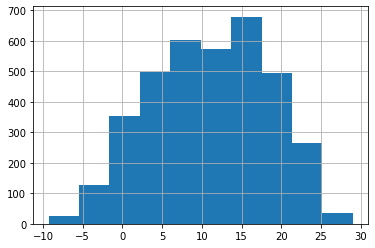

In [35]:
dataset["BASEL_temp_mean"].hist()

<AxesSubplot:>

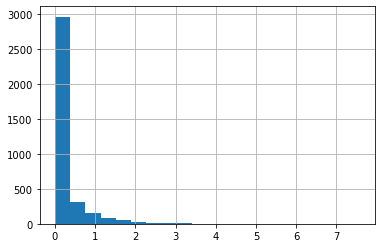

In [38]:
dataset["BASEL_precipitation"].hist(bins=20)

<AxesSubplot:>

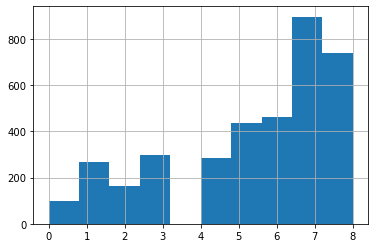

In [40]:
dataset["BASEL_cloud_cover"].hist()

<AxesSubplot:>

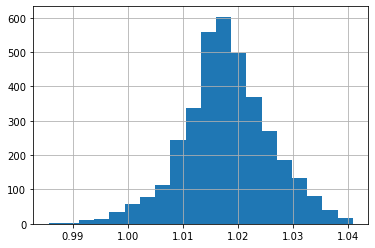

In [41]:
dataset["BASEL_pressure"].hist(bins=20)